# Análise Exploratória

O Bitcoin é uma moeda digital descentralizada, criada em 2009 por uma entidade sob o pseudônimo de Satoshi Nakamoto, projetada para permitir transações financeiras sem a necessidade de intermediários, como bancos ou governos. Baseado na tecnologia blockchain, o Bitcoin utiliza um registro público e distribuído para garantir a transparência, segurança e imutabilidade das transações. Seu fornecimento total é limitado a 21 milhões de unidades, e novas moedas são geradas por meio do processo de mineração, no qual computadores resolvem problemas criptográficos complexos. Considerado tanto uma forma de pagamento quanto uma reserva de valor, o Bitcoin tem sido amplamente adotado como um ativo de investimento e um mecanismo de proteção contra inflação em alguns contextos econômicos.

O que torna o Bitcoin um ativo tão atrativo para a maioria dos investidores pode ser resumido nas seguintes características:

1.	**Descentralização** – O Bitcoin opera em uma rede peer-to-peer, sem controle de governos ou instituições financeiras. Sua estrutura é baseada no blockchain, um livro-razão distribuído que registra todas as transações de forma imutável.

2.	**Oferta Limitada** – Diferente das moedas fiduciárias, o Bitcoin tem um suprimento máximo de 21 milhões de unidades, o que protege contra inflação e desvalorização monetária ao longo do tempo.

3.	**Segurança e Imutabilidade** – As transações de Bitcoin são protegidas por criptografia de chave pública e registradas em blocos encadeados, tornando-as praticamente impossíveis de serem alteradas ou fraudadas.

4.	**Transparência e Pseudonimato** – Todas as transações são visíveis publicamente no blockchain, garantindo transparência, mas os usuários são identificados apenas por seus endereços criptográficos, preservando a privacidade.

5.	**Divisibilidade e Portabilidade** – O Bitcoin é altamente divisível (até 8 casas decimais, com a menor unidade chamada satoshi) e pode ser transferido globalmente de forma rápida e com custos relativamente baixos, sem necessidade de intermediários.

Iremos utilizar a biblioteca ccxt para obter dados de mercado sobre o Bitcoin. A biblioteca CCXT (CryptoCurrency eXchange Trading Library) é uma ferramenta unificada para acessar APIs de diversas exchanges de criptomoedas, facilitando a negociação, obtenção de dados de mercado e gerenciamento de contas de forma padronizada em múltiplas plataformas.

In [1]:
# Instalar as dependências necessárias para o projeto
%pip install ccxt
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar as bibliotecas necessárias
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
from io import StringIO

A função fetch_all_binance_data coleta todos os dados históricos de preço no formato OHLCV (Open, High, Low, Close, Volume) para o par de negociação BTC/USDT na Binance, com granularidade diária por padrão. Ela inicializa a conexão com a exchange usando a biblioteca CCXT e começa a buscar dados a partir de 1º de janeiro de 2017. Em um loop contínuo, ela coleta dados em blocos de até 1000 registros por vez (limite da API), avançando o ponto inicial (since) após cada lote e adicionando os dados à lista all_data. Após concluir o processo, os dados são convertidos em um DataFrame do Pandas, com os timestamps formatados para o tipo de data, e o resultado final é ordenado cronologicamente antes de ser retornado. O uso de time.sleep(1) reduz a carga na API durante a execução.

In [5]:
# =============================================================================
# Função para baixar dados de OHLCV do par BTC/USDT (Binance)
# OHLCV = Open, High, Low, Close, Volume
# =============================================================================
def fetch_all_binance_data(symbol="BTC/USDT", timeframe="1d"):
    exchange = ccxt.binance()
    since = exchange.parse8601("2017-01-01T00:00:00Z")
    all_data = []
    max_limit = 1000

    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=max_limit)
        if not ohlcv:
            break
        all_data.extend(ohlcv)
        since = ohlcv[-1][0] + 1  # atualiza "since" para continuar baixando
        print(f"Baixados {len(all_data)} registros...")
        time.sleep(1)  # pequeno intervalo para evitar limite de requisições

    # Log de debug: vamos ver as primeiras 5 linhas brutas de all_data
    print("\nExemplo de registros de 'all_data' (primeiros 5):")
    print(all_data[:5])

    # Monta o DataFrame
    df = pd.DataFrame(all_data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

    # Ordena e mantém apenas as colunas desejadas
    df = df[["timestamp", "open", "high", "low", "close", "volume"]].sort_values("timestamp")
    return df

In [6]:
# Coletar os dados de cotação
btc_data = fetch_all_binance_data()

Baixados 1000 registros...
Baixados 2000 registros...
Baixados 2765 registros...

Exemplo de registros de 'all_data' (primeiros 5):
[[1502928000000, 4261.48, 4485.39, 4200.74, 4285.08, 795.150377], [1503014400000, 4285.08, 4371.52, 3938.77, 4108.37, 1199.888264], [1503100800000, 4108.37, 4184.69, 3850.0, 4139.98, 381.309763], [1503187200000, 4120.98, 4211.08, 4032.62, 4086.29, 467.083022], [1503273600000, 4069.13, 4119.62, 3911.79, 4016.0, 691.74306]]


O volume retornado pela API fetch_ohlcv da Binance (e outras exchanges) refere-se ao volume de negociação em termos da criptomoeda base no par de negociação. No caso do par BTC/USDT, o volume representa a quantidade total de BTC negociado no período especificado (por exemplo, um dia no timeframe '1d').

Esse volume não é diretamente em dólares, mas pode ser convertido multiplicando o volume de BTC pelo preço médio (por exemplo, o preço de fechamento). Também não representa a quantidade de transações, mas sim a soma total da quantidade de criptomoeda negociada em todas as transações no período.

In [7]:
# Dados incluem final de semana
btc_data.head(7)

,timestamp,open,high,low,close,volume
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
5,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858
6,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565


In [8]:
btc_data.tail()

,timestamp,open,high,low,close,volume
2760,2025-03-08,86801.74,86897.25,85218.47,86222.45,12989.23054
2761,2025-03-09,86222.46,86500.00,80000.00,80734.37,26115.39345
2762,2025-03-10,80734.48,84123.46,77459.91,78595.86,47633.38405
2763,2025-03-11,78595.86,83617.40,76606.00,82932.99,48770.06853
2764,2025-03-12,82932.99,83783.26,81296.00,82634.40,9082.24342


In [9]:
# Estatísticas descritivas
descriptive_stats = btc_data.describe()
display(descriptive_stats)

,timestamp,open,high,low,close,volume
count,2765,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000
mean,2021-05-30 00:00:00,28764.653298,29452.308955,28022.646684,28793.050684,67132.840739
min,2017-08-17 00:00:00,3188.010000,3276.500000,2817.000000,3189.020000,228.108068
25%,2019-07-09 00:00:00,8663.370000,8880.000000,8365.770000,8679.710000,27687.495670
50%,2021-05-30 00:00:00,20905.580000,21558.410000,20478.610000,20954.920000,43223.481682
75%,2023-04-21 00:00:00,43160.000000,44101.120000,42258.100000,43160.900000,70379.866450
max,2025-03-12 00:00:00,106143.820000,109588.000000,105321.490000,106143.820000,760705.362783
std,NaN,24341.681177,24860.460198,23787.944991,24358.774619,79373.805955


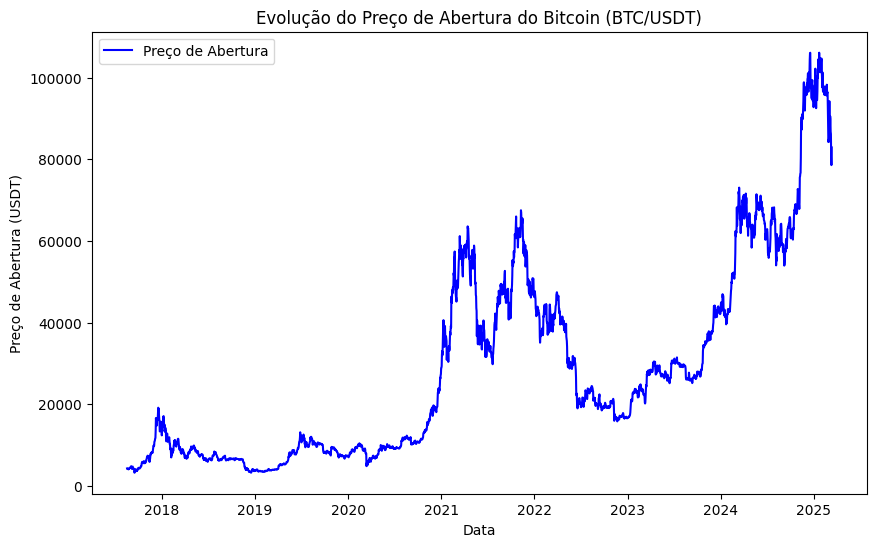

In [10]:
# Visualização do Preço de Abertura ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(
    btc_data["timestamp"], btc_data["open"], label="Preço de Abertura", color="blue"
)
plt.xlabel("Data")
plt.ylabel("Preço de Abertura (USDT)")
plt.title("Evolução do Preço de Abertura do Bitcoin (BTC/USDT)")
plt.legend()
plt.show()

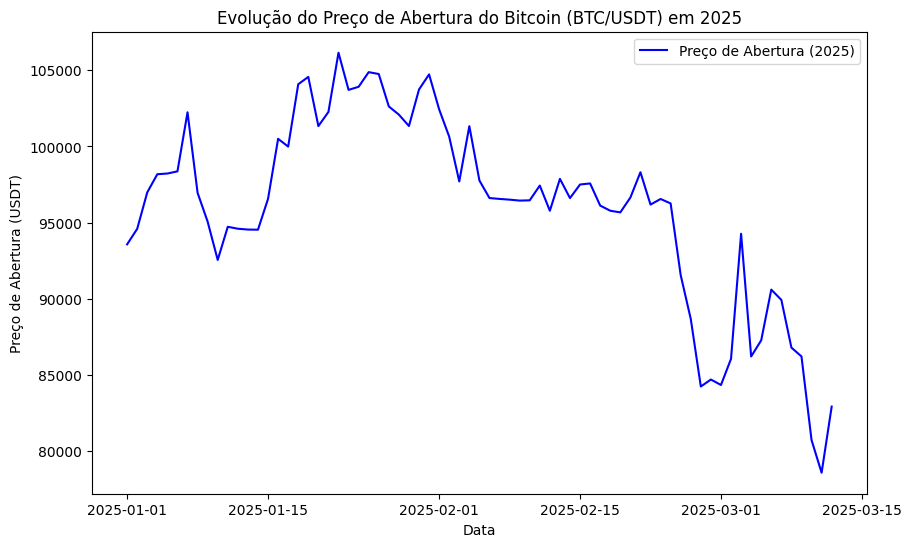

In [11]:
# Filtrando apenas os dados de 2025
btc_data_2025 = btc_data[btc_data["timestamp"].dt.year == 2025]

# Visualização do Preço de Abertura ao longo do tempo em 2025
plt.figure(figsize=(10, 6))
plt.plot(
    btc_data_2025["timestamp"],
    btc_data_2025["open"],
    label="Preço de Abertura (2025)",
    color="blue",
)
plt.xlabel("Data")
plt.ylabel("Preço de Abertura (USDT)")
plt.title("Evolução do Preço de Abertura do Bitcoin (BTC/USDT) em 2025")
plt.legend()
plt.show()

In [12]:
# Incluindo colunas de média móvel (moving average) de 3 dias
btc_data["open_ma3"] = btc_data["open"].rolling(window=3).mean()
btc_data["close_ma3"] = btc_data["close"].rolling(window=3).mean()
btc_data["volume_ma3"] = btc_data["volume"].rolling(window=3).mean()
btc_data["high_ma3"] = btc_data["high"].rolling(window=3).mean()
btc_data["low_ma3"] = btc_data["low"].rolling(window=3).mean()

In [13]:
# Criando colunas de shift para o preço de abertura e fechamento do dia anterior
btc_data["open_shift"] = btc_data["open"].shift(1)
btc_data["close_shift"] = btc_data["close"].shift(1)

In [14]:
# Criando uma feature de indicacao (target) onde:
# se a variacao percentual entre a abertura e o fechamento for positiva (> 0.5%), a variavel indicacao recebe 1
# se a variacao percentual entre a abertura e o fechamento for menor que 0.5%, a variavel indicacao recebe 0
btc_data["variation"] = (btc_data["close"] - btc_data["open"]) / btc_data["open"]
btc_data["indication"] = (btc_data["variation"] > 0.005).astype(int)

In [16]:
btc_data.tail()

,timestamp,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,low_ma3,open_shift,close_shift,variation,indication
2760,2025-03-08,86801.74,86897.25,85218.47,86222.45,12989.23054,89113.206667,87652.030000,35104.012230,90330.303333,85907.166667,89931.88,86801.75,-0.006674,0
2761,2025-03-09,86222.46,86500.00,80000.00,80734.37,26115.39345,87652.026667,84586.190000,32361.660373,88226.756667,83295.166667,86801.74,86222.45,-0.063650,0
2762,2025-03-10,80734.48,84123.46,77459.91,78595.86,47633.38405,84586.226667,81850.893333,28912.669347,85840.236667,80892.793333,86222.46,80734.37,-0.026490,0
2763,2025-03-11,78595.86,83617.40,76606.00,82932.99,48770.06853,81850.933333,80754.406667,40839.615343,84746.953333,78021.970000,80734.48,78595.86,0.055183,1
2764,2025-03-12,82932.99,83783.26,81296.00,82634.40,9082.24342,80754.443333,81387.750000,35161.898667,83841.373333,78453.970000,78595.86,82932.99,-0.003600,0


In [17]:
# Correlação entre as variáveis
correlation_matrix = btc_data.corr()
display(correlation_matrix)

,timestamp,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,low_ma3,open_shift,close_shift,variation,indication
timestamp,1.000000,0.782441,0.779970,0.786576,0.782646,0.187061,0.782505,0.782709,0.196238,0.779947,0.786696,0.782172,0.782377,-0.009114,-0.053468
open,0.782441,1.000000,0.999435,0.999126,0.998838,-0.093057,0.999377,0.999729,-0.097816,0.999514,0.999463,0.998835,1.000000,-0.025161,-0.036043
high,0.779970,0.999435,1.000000,0.998915,0.999494,-0.088797,0.998917,0.999623,-0.094958,0.999479,0.998964,0.998425,0.999435,-0.006042,-0.019284
low,0.786576,0.999126,0.998915,1.000000,0.999343,-0.099228,0.998399,0.999282,-0.100961,0.998583,0.999294,0.997864,0.999126,-0.003838,-0.022838
close,0.782646,0.998838,0.999494,0.999343,1.000000,-0.093761,0.998283,0.999378,-0.097698,0.998824,0.998808,0.997781,0.998838,0.010715,-0.008602
volume,0.187061,-0.093057,-0.088797,-0.099228,-0.093761,1.000000,-0.093393,-0.093839,0.944826,-0.090746,-0.096974,-0.092893,-0.093390,-0.006779,0.025271
open_ma3,0.782505,0.999377,0.998917,0.998399,0.998283,-0.093393,1.000000,0.999635,-0.097586,0.999788,0.999591,0.999730,0.999378,-0.024806,-0.033992
close_ma3,0.782709,0.999729,0.999623,0.999282,0.999378,-0.093839,0.999635,1.000000,-0.097762,0.999791,0.999709,0.999376,0.999729,-0.013095,-0.025758
volume_ma3,0.196238,-0.097816,-0.094958,-0.100961,-0.097698,0.944826,-0.097586,-0.097762,1.000000,-0.094629,-0.101178,-0.097625,-0.097816,0.004560,0.012469
high_ma3,0.779947,0.999514,0.999479,0.998583,0.998824,-0.090746,0.999788,0.999791,-0.094629,1.000000,0.999372,0.999520,0.999515,-0.018352,-0.028324


O meu target será a feature de indication. Por enquanto ainda não encontramos nenhuma correlação relevante entre as features que seja promissora para o nosso modelo de machine learning. Ainda temos muita redundância que depois iremos tratar.

## Índice VIX

O índice VIX, conhecido como Índice de Volatilidade ou “Índice do Medo”, mede a expectativa de volatilidade do mercado de ações dos Estados Unidos para os próximos 30 dias, com base nas opções do S&P 500. Calculado pela Chicago Board Options Exchange (CBOE), o VIX reflete o nível de incerteza e risco percebido pelos investidores, sendo frequentemente utilizado como um indicador de aversão ao risco. Quando o VIX está alto, geralmente indica maior ansiedade no mercado, sugerindo volatilidade futura elevada. Por outro lado, valores baixos indicam períodos de estabilidade. Ele é amplamente usado por traders e analistas para antecipar movimentos de mercado e ajustar estratégias de hedge ou investimento.

A economia americana é uma grande influenciadora do mercado financeiro mundial, e a maior influenciadora do mercado de criptomoedas. Utilizar o VIX como uma ferramenta para indicar a tendência de mercado parece uma ótima ideia.

Para coletar os dados do VIX poderíamos utilizar a biblioteca yfinance, que permite acessar e baixar dados financeiros históricos e em tempo real de ações, índices, moedas e outros ativos diretamente do Yahoo Finance para análise e modelagem financeira. Contudo, ela tem restrições de rate limit que dificultam muito a nossa abordagem, de forma que preferimos baixar o histórico do VIX completo diretamente do arquivo csv fornecido pela própria CBOE, responsável por manter o índice.

In [18]:
# -----------------------------------------------------------------------------
# Função para baixar dados do VIX diretamente do CSV oficial da CBOE
# -----------------------------------------------------------------------------
def fetch_vix_data(btc_data):
    """
    Faz o download dos dados históricos do VIX a partir do CSV oficial da CBOE.
    Filtra o período com base no DataFrame 'btc_data'.
    """
    url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
    response = requests.get(url)
    response.raise_for_status()  # Lança exceção se houver erro na requisição

    csv_data = StringIO(response.text)
    vix_raw = pd.read_csv(csv_data)

    print("\nColunas originais do CSV da CBOE (VIX):", vix_raw.columns.tolist())
    print("Exemplo das primeiras 5 linhas (brutas) do VIX:")
    print(vix_raw.head())

    # Normaliza todas as colunas para maiúsculas
    vix_raw.columns = [col.strip().upper() for col in vix_raw.columns]

    # Dicionário para renomear
    rename_dict = {
        "DATE": "timestamp",
        "OPEN": "vix_open",
        "HIGH": "vix_high",
        "LOW": "vix_low",
        "CLOSE": "vix_close",
    }
    # Renomeia apenas se a coluna existir
    for original, destino in rename_dict.items():
        if original in vix_raw.columns:
            vix_raw.rename(columns={original: destino}, inplace=True)

    # Verifica se a coluna "timestamp" realmente existe depois do rename
    if "timestamp" not in vix_raw.columns:
        raise ValueError(
            f"Coluna 'timestamp' não encontrada após o rename. "
            f"Colunas disponíveis: {vix_raw.columns.tolist()}"
        )

    # Converte para datetime
    vix_raw["timestamp"] = pd.to_datetime(vix_raw["timestamp"])

    # Filtra o período com base na data mínima e máxima do DataFrame de BTC
    start_date = btc_data["timestamp"].min()
    end_date = btc_data["timestamp"].max()
    print("\n[DEBUG] Período do BTC para filtragem do VIX:")
    print("  data mínima:", start_date, "| data máxima:", end_date)

    mask = (vix_raw["timestamp"] >= start_date) & (vix_raw["timestamp"] <= end_date)
    vix = vix_raw.loc[mask].copy()

    # Ordena por timestamp
    vix.sort_values("timestamp", inplace=True)

    # Cria colunas de variação e média
    vix["vix_variation"] = vix["vix_high"] - vix["vix_low"]
    vix["vix_mean"] = (vix["vix_high"] + vix["vix_low"]) / 2

    return vix.reset_index(drop=True)

In [19]:
vix_data = fetch_vix_data(btc_data)


Colunas originais do CSV da CBOE (VIX): ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']
Exemplo das primeiras 5 linhas (brutas) do VIX:
         DATE   OPEN   HIGH    LOW  CLOSE
0  01/02/1990  17.24  17.24  17.24  17.24
1  01/03/1990  18.19  18.19  18.19  18.19
2  01/04/1990  19.22  19.22  19.22  19.22
3  01/05/1990  20.11  20.11  20.11  20.11
4  01/08/1990  20.26  20.26  20.26  20.26

[DEBUG] Período do BTC para filtragem do VIX:
  data mínima: 2017-08-17 00:00:00 | data máxima: 2025-03-12 00:00:00


In [20]:
vix_data.head()

,timestamp,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean
0,2017-08-17,11.81,15.77,11.54,15.55,4.23,13.655
1,2017-08-18,15.38,16.04,13.32,14.26,2.72,14.680
2,2017-08-21,14.59,14.74,13.07,13.19,1.67,13.905
3,2017-08-22,12.60,12.94,11.35,11.35,1.59,12.145
4,2017-08-23,11.51,12.59,11.39,12.25,1.20,11.990


In [21]:
# Média móvel (moving average) de 3 dias
vix_data["vix_open_ma3"] = vix_data["vix_open"].rolling(window=3).mean()
vix_data["vix_close_ma3"] = vix_data["vix_close"].rolling(window=3).mean()
vix_data["vix_variation_ma3"] = vix_data["vix_variation"].rolling(window=3).mean()
vix_data["vix_mean_ma3"] = vix_data["vix_mean"].rolling(window=3).mean()

In [22]:
vix_data.head()

,timestamp,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
0,2017-08-17,11.81,15.77,11.54,15.55,4.23,13.655,NaN,NaN,NaN,NaN
1,2017-08-18,15.38,16.04,13.32,14.26,2.72,14.680,NaN,NaN,NaN,NaN
2,2017-08-21,14.59,14.74,13.07,13.19,1.67,13.905,13.926667,14.333333,2.873333,14.080000
3,2017-08-22,12.60,12.94,11.35,11.35,1.59,12.145,14.190000,12.933333,1.993333,13.576667
4,2017-08-23,11.51,12.59,11.39,12.25,1.20,11.990,12.900000,12.263333,1.486667,12.680000


In [23]:
# Unir os dados de BTC e VIX pelo timestamp
btc_data["date"] = btc_data["timestamp"].dt.date
vix_data["date"] = vix_data["timestamp"].dt.date

merged_data = pd.merge(btc_data, vix_data, on="date", how="inner")

In [24]:
# Remover a coluna duplicada de date
merged_data.drop(["date"], axis=1, inplace=True)

In [ ]:
merged_data.head(14)

,timestamp_x,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,...,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,NaN,NaN,NaN,NaN,...,11.81,15.77,11.54,15.55,4.23,13.655,NaN,NaN,NaN,NaN
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,NaN,NaN,NaN,NaN,...,15.38,16.04,13.32,14.26,2.72,14.680,NaN,NaN,NaN,NaN
2,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,4099.493333,4080.756667,513.378615,4171.796667,...,14.59,14.74,13.07,13.19,1.67,13.905,13.926667,14.333333,2.873333,14.080000
3,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858,4068.703333,4047.430000,708.503647,4145.173333,...,12.60,12.94,11.35,11.35,1.59,12.145,14.190000,12.933333,1.993333,13.576667
4,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565,4041.710000,4056.670000,886.521494,4163.413333,...,11.51,12.59,11.39,12.25,1.20,11.990,12.900000,12.263333,1.486667,12.680000
5,2017-08-24,4147.00,4371.68,4085.01,4316.01,787.418753,4067.666667,4156.673333,918.413392,4247.433333,...,12.06,12.83,11.55,12.23,1.28,12.190,12.056667,11.943333,1.356667,12.108333
6,2017-08-25,4316.01,4453.91,4247.48,4280.68,573.612740,4167.670000,4236.900000,787.389353,4363.796667,...,12.20,12.45,11.10,11.28,1.35,11.775,11.923333,11.920000,1.276667,11.985000
7,2017-08-28,4310.01,4399.82,4124.54,4386.69,603.841616,4307.743333,4344.713333,394.214090,4388.940000,...,12.09,12.11,11.23,11.32,0.88,11.670,12.116667,11.610000,1.170000,11.878333
8,2017-08-29,4353.65,4625.85,4313.55,4587.48,603.545028,4332.056667,4428.060000,519.359743,4475.223333,...,13.33,14.34,11.48,11.70,2.86,12.910,12.540000,11.433333,1.696667,12.118333
9,2017-08-30,4564.52,4647.51,4416.01,4555.14,808.468771,4409.393333,4509.770000,671.951805,4557.726667,...,11.40,11.98,10.96,11.22,1.02,11.470,12.273333,11.413333,1.586667,12.016667


A presença de valores nulos no dataset pode comprometer a qualidade do modelo de machine learning, pois podem introduzir viés ou dificultar a aprendizagem dos padrões corretos nos dados. Como o algoritmo precisa de informações completas para realizar previsões confiáveis, a manutenção de linhas com valores ausentes pode resultar em perda de acurácia e inconsistências na análise. Além disso, como os dados históricos do Bitcoin e do VIX são fundamentais para a tomada de decisão sobre operar ou não, a ausência de informações pode levar a decisões equivocadas. Portanto, excluir linhas com valores nulos garante que o modelo trabalhe apenas com dados completos e confiáveis, melhorando a precisão e a robustez das previsões.

In [27]:
# Excluindo as linhas com valores nulos
merged_data.dropna(inplace=True)

In [28]:
merged_data.shape

(1921, 26)

In [29]:
# Correlação entre as variáveis
correlation_matrix = merged_data.corr()
display(correlation_matrix)

,timestamp_x,open,high,low,close,volume,open_ma3,close_ma3,volume_ma3,high_ma3,...,vix_open,vix_high,vix_low,vix_close,vix_variation,vix_mean,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
timestamp_x,1.000000,0.781539,0.779125,0.785681,0.781764,0.208189,0.781356,0.781822,0.202817,0.779022,...,0.047910,0.029386,0.065668,0.043548,-0.083326,0.045948,0.048311,0.043781,-0.096779,0.046158
open,0.781539,1.000000,0.999361,0.999029,0.998582,-0.088208,0.999310,0.999675,-0.094707,0.999466,...,-0.121513,-0.117552,-0.118201,-0.118858,-0.076174,-0.118673,-0.124017,-0.123481,-0.092913,-0.122379
high,0.779125,0.999361,1.000000,0.998932,0.999434,-0.084616,0.998796,0.999595,-0.091866,0.999430,...,-0.119278,-0.116037,-0.116687,-0.117649,-0.075166,-0.117148,-0.121765,-0.121495,-0.090136,-0.120290
low,0.785681,0.999029,0.998932,1.000000,0.999273,-0.093806,0.998277,0.999247,-0.097742,0.998534,...,-0.123723,-0.122136,-0.120723,-0.122872,-0.085065,-0.122360,-0.125428,-0.125846,-0.097608,-0.124456
close,0.781764,0.998582,0.999434,0.999273,1.000000,-0.088975,0.998013,0.999264,-0.094458,0.998663,...,-0.120807,-0.119254,-0.118634,-0.121054,-0.080904,-0.119815,-0.123003,-0.123503,-0.093674,-0.122023
volume,0.208189,-0.088208,-0.084616,-0.093806,-0.088975,1.000000,-0.087683,-0.088328,0.958379,-0.085430,...,0.348310,0.331403,0.363394,0.344978,0.129275,0.348160,0.345678,0.346306,0.117624,0.346450
open_ma3,0.781356,0.999310,0.998796,0.998277,0.998013,-0.087683,1.000000,0.999598,-0.094311,0.999767,...,-0.119958,-0.115508,-0.116878,-0.117346,-0.072779,-0.116940,-0.123591,-0.122414,-0.089774,-0.121412
close_ma3,0.781822,0.999675,0.999595,0.999247,0.999264,-0.088328,0.999598,1.000000,-0.094607,0.999785,...,-0.120818,-0.117471,-0.117953,-0.119148,-0.076596,-0.118517,-0.123714,-0.123298,-0.092370,-0.122112
volume_ma3,0.202817,-0.094707,-0.091866,-0.097742,-0.094458,0.958379,-0.094311,-0.094607,1.000000,-0.091389,...,0.346567,0.323730,0.361626,0.339420,0.107444,0.343094,0.350068,0.347714,0.119097,0.348932
high_ma3,0.779022,0.999466,0.999430,0.998534,0.998663,-0.085430,0.999767,0.999785,-0.091389,1.000000,...,-0.118604,-0.114444,-0.115861,-0.116381,-0.071938,-0.115890,-0.121938,-0.120977,-0.088067,-0.119929


## Insights

1.	**Correlação negativa entre o VIX e os preços do Bitcoin**
Os valores negativos de correlação entre as variáveis do VIX (abertura, fechamento, média) e os preços do Bitcoin (open, high, low, close) indicam que quando o VIX sobe, o preço do Bitcoin tende a cair. Isso confirma a hipótese de que o aumento do medo no mercado leva a uma fuga de ativos de risco, como o Bitcoin.

2.	**Volume do Bitcoin e VIX possuem correlação positiva**
O volume de negociação do Bitcoin apresenta uma correlação positiva moderada com o VIX, o que sugere que períodos de maior volatilidade e medo no mercado podem estar associados a um aumento no volume de negociação do Bitcoin, possivelmente devido a liquidações ou operações defensivas.

3.	**Correlação forte entre as métricas do VIX**
As variáveis do VIX, como abertura, fechamento e média móvel, possuem correlações extremamente altas entre si, o que indica que o VIX segue uma tendência bastante coesa e previsível ao longo do tempo. Isso pode ser útil para suavizar dados e melhorar a acurácia do modelo.

4.	**Correlação fraca entre a variação do Bitcoin e o VIX**
A variação diária do Bitcoin tem uma correlação negativa relativamente fraca com o VIX, sugerindo que, apesar da relação inversa entre medo do mercado e preços do Bitcoin, outros fatores também influenciam a volatilidade diária da criptomoeda.

5.	**Indicadores de média móvel podem melhorar previsões**
A correlação entre médias móveis do VIX e do Bitcoin com seus respectivos preços sugere que o uso dessas médias pode ajudar a suavizar oscilações de curto prazo e melhorar a identificação de tendências de mercado, sendo uma abordagem útil para a estratégia do modelo preditivo.

Durante períodos de alta volatilidade, o **aumento no índice VIX é frequentemente associado a uma maior aversão ao risco, levando investidores a vender ativos de risco, como o Bitcoin**, e buscar refúgio em ativos mais estáveis, como ouro ou títulos do governo. A correlação moderada entre o volume de negociação e o VIX indica que o interesse no mercado de Bitcoin aumenta durante esses períodos, possivelmente devido à especulação ou ajustes em portfólios. A média móvel de 3 períodos do volume (volume_ma3) pode identificar picos de interesse que precedem movimentos significativos no preço, sugerindo oportunidades de antecipação.

In [30]:
# salvando o dataframe em um arquivo CSV
merged_data.to_csv("merged_data.csv", index=False)